# 김형준 박사님 논문 네트워크 구현
- A novel deep learning-based forecasting model optimized by heuristic algorithm for energy management of microgrid, Applied Energy, 332 (2023)

## LSTM+GAM 구조
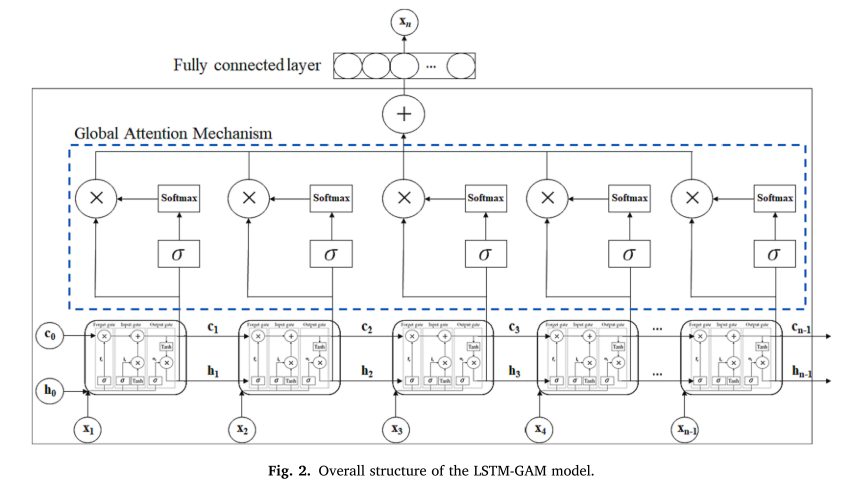
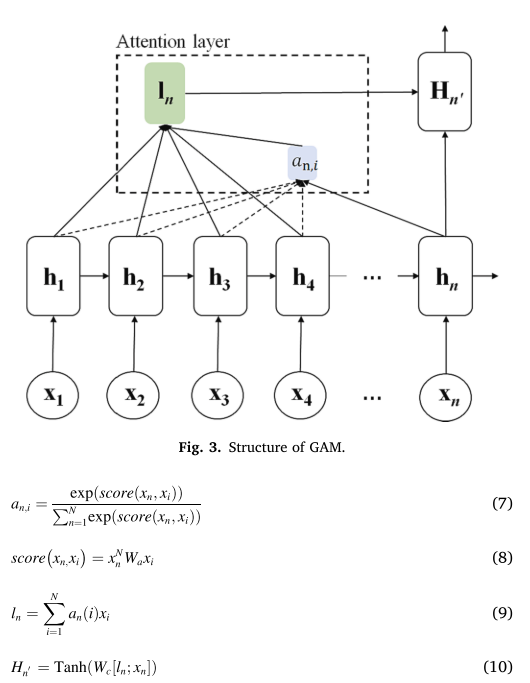

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# LSTM 네트워크 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(LSTM, self).__init__()
        self.hidden_size1 = hidden_size1  # 첫 번째 은닉층의 크기 설정
        self.hidden_size2 = hidden_size2  # 두 번째 은닉층의 크기 설정
        self.num_layers = 2  # LSTM 레이어의 수를 2로 고정
        self.lstm1 = nn.LSTM(input_size, hidden_size1, 1, batch_first=True)  # 첫 번째 LSTM 레이어 정의
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, 1, batch_first=True)  # 두 번째 LSTM 레이어 정의
        self.fc = nn.Linear(hidden_size2, 1)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0_1 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)  # 첫 번째 LSTM 레이어의 초기 은닉 상태 설정
        c_0_1 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)  # 첫 번째 LSTM 레이어의 초기 셀 상태 설정
        h_0_2 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)  # 두 번째 LSTM 레이어의 초기 은닉 상태 설정
        c_0_2 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)  # 두 번째 LSTM 레이어의 초기 셀 상태 설정
        
        out, _ = self.lstm1(x, (h_0_1, c_0_1))  # 첫 번째 LSTM 레이어를 통과시킴
        out, _ = self.lstm2(out, (h_0_2, c_0_2))  # 두 번째 LSTM 레이어를 통과시킴
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 전결합층에 통과시킴
        return out  # 최종 출력 반환

# 글로벌 어텐션 메커니즘 정의
class GlobalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GlobalAttention, self).__init__()
        self.wa = nn.Linear(hidden_size, hidden_size, bias=False)  # 어텐션 가중치 Wa 정의
        self.wc = nn.Linear(hidden_size * 2, hidden_size, bias=False)  # 컨텍스트 벡터와 은닉 상태를 결합하는 가중치 Wc 정의

    def forward(self, hn, h):
        # 수식 (8): score(xn, xi) = xn Wa xi
        # hn: (batch_size, 1, hidden_size)
        # h: (batch_size, seq_len, hidden_size)
        # self.wa(h): (batch_size, seq_len, hidden_size)
        # self.wa(h).transpose(1, 2): (batch_size, hidden_size, seq_len)
        # hn.transpose(1, 2): (batch_size, hidden_size, 1)
        scores = torch.bmm(hn, self.wa(h).transpose(1, 2)).squeeze(1)  # 각 타임스텝의 점수 계산
        
        # 수식 (7): an,i = exp(score(xn, xi)) / sum(exp(score(xn, xi)))
        attn_weights = torch.softmax(scores, dim=1).unsqueeze(2)  # 소프트맥스를 통해 어텐션 가중치 계산
        
        # 수식 (9): ln = sum(an(i)xi)
        # attn_weights: (batch_size, seq_len, 1)
        # h: (batch_size, seq_len, hidden_size)
        attn_weights = attn_weights.repeat(1, 1, h.size(2))  # attn_weights를 h와 동일한 크기로 반복
        context = torch.sum(attn_weights * h, dim=1)  # 가중합 계산
        
        # 수식 (10): Hn' = Tanh(Wc[ln; xn])
        # context: (batch_size, hidden_size)
        # hn.squeeze(1): (batch_size, hidden_size)
        hn_prime = torch.tanh(self.wc(torch.cat((context, hn.squeeze(1)), dim=1)))  # 최종 컨텍스트 벡터 계산
        return hn_prime  # 최종 컨텍스트 벡터 반환

# LSTM과 글로벌 어텐션 메커니즘을 결합한 네트워크 정의
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTMWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, 1, batch_first=True)  # 첫 번째 LSTM 레이어 정의
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, 1, batch_first=True)  # 두 번째 LSTM 레이어 정의
        self.attention = GlobalAttention(hidden_size2)  # 글로벌 어텐션 레이어 정의
        self.fc = nn.Linear(hidden_size2, output_size)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0_1 = torch.zeros(1, x.size(0), self.lstm1.hidden_size).to(x.device)  # 첫 번째 LSTM 레이어의 초기 은닉 상태 설정
        c_0_1 = torch.zeros(1, x.size(0), self.lstm1.hidden_size).to(x.device)  # 첫 번째 LSTM 레이어의 초기 셀 상태 설정
        h_0_2 = torch.zeros(1, x.size(0), self.lstm2.hidden_size).to(x.device)  # 두 번째 LSTM 레이어의 초기 은닉 상태 설정
        c_0_2 = torch.zeros(1, x.size(0), self.lstm2.hidden_size).to(x.device)  # 두 번째 LSTM 레이어의 초기 셀 상태 설정

        h, _ = self.lstm1(x, (h_0_1, c_0_1))  # 첫 번째 LSTM 레이어를 통과시킴
        h, _ = self.lstm2(h, (h_0_2, c_0_2))  # 두 번째 LSTM 레이어를 통과시킴
        hn = h[:, -1, :].unsqueeze(1)  # 마지막 타임스텝의 은닉 상태를 선택
        hn_prime = self.attention(hn, h)  # 어텐션 메커니즘 적용
        output = self.fc(hn_prime)  # 최종 출력을 전결합층에 통과시킴
        return output  # 최종 출력 반환

In [2]:
# 하이퍼파라미터 설정
input_size = 10
hidden_size1 = 50  # 첫 번째 은닉층의 뉴런 수
hidden_size2 = 30  # 두 번째 은닉층의 뉴런 수
output_size = 1
learning_rate = 0.001
num_epochs = 100

# 데이터 생성
x_train = torch.randn(64, 100, input_size)  # 64개 샘플로 학습 데이터 생성, (batch_size, seq_len, input_size(=feature size))
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)  # 16개 샘플로 검증 데이터 생성
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)  # 16개 샘플로 테스트 데이터 생성
y_test = torch.randn(16, output_size)

# 모델 초기화
model_lstm = LSTM(input_size, hidden_size1, hidden_size2)
model_attention = LSTMWithAttention(input_size, hidden_size1, hidden_size2, output_size)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
optimizer_attention = optim.Adam(model_attention.parameters(), lr=learning_rate)

In [3]:
# 학습 함수
def train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses

# 테스트 손실 계산
def test_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    return test_loss.item()



In [ ]:
# 모델 학습
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, x_train, y_train, x_val, y_val, num_epochs)
train_losses_attention, val_losses_attention = train_model(model_attention, optimizer_attention, x_train, y_train, x_val, y_val, num_epochs)
test_loss_lstm = test_model(model_lstm, x_test, y_test)
test_loss_attention = test_model(model_attention, x_test, y_test)

print(f'Test Loss for LSTM: {test_loss_lstm:.4f}')
print(f'Test Loss for LSTM with Attention: {test_loss_attention:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_attention, label='LSTM with Attention Train Loss')
plt.plot(val_losses_attention, label='LSTM with Attention Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# GA-AWPSO 
* Genetic Algorithm-Adaptive Weight Particle Swarm Optimization
* 유전자 알고리즘(GA)
    - 기반: 자연 진화에서 영감을 받은 메타휴리스틱 최적화 알고리즘입니다.
    - 작동 원리: 여러 세대에 걸쳐 최적의 하이퍼파라미터를 찾아내기 위해 진화 과정을 시뮬레이션합니다. 각 세대마다 하이퍼파라미터 설정의 적합도 함수를 평가하고, 선택, 교차, 돌연변이 연산을 통해 새로운 하이퍼파라미터를 생성합니다.
    - 장점: 하이퍼파라미터 공간을 무작위로 탐색할 수 있는 기회를 제공하며, 다양한 해를 탐색할 수 있습니다.
    - 단점: 하이퍼파라미터 조합이 매우 크고 복잡하여 계산 부담이 증가할 수 있습니다. 또한, 선택되지 않은 개체는 잃게 되는 문제가 있습니다

* 입자 군집 최적화(PSO)
    - 기반: 새 떼와 같은 군집 생물의 움직임을 모방한 군집 기반 메타휴리스틱 알고리즘입니다.
    - 작동 원리: 문제의 하이퍼파라미터를 나타내는 여러 입자가 검색 공간을 이동하며 지속적으로 진화합니다. 각 입자는 최적의 위치를 찾기 위해 개별적이면서도 군집적으로 움직입니다.
    - 장점: 정보 메모리를 유지하여 이전에 탐색한 위치를 기억하며, 계산 속도가 빠릅니다.
    - 단점: 선택 연산자가 없어 잘못된 개체에 계산 시간을 낭비할 수 있으며, 다중 봉우리 문제에서는 고정된 관성 가중치와 학습 인자로 인해 지역 최적해에 빠질 위험이 있습니다

* GA-AWPSO 알고리즘의 결합
    - 결합 목적: GA와 PSO 알고리즘의 강점을 모두 활용하여 최적의 하이퍼파라미터를 효율적으로 찾기 위함입니다.
    - 작동 방식: PSO 알고리즘을 통해 초기 군집을 형성하고, 각 반복 단계에서 GA를 적용하여 선택된 개체들을 교차 및 돌연변이하여 새로운 개체를 생성합니다. 이를 통해 군집의 다양성을 증가시키고, 지역 최적해에 빠지는 문제를 방지할 수 있습니다.
    - 장점: GA의 교차 및 돌연변이 연산을 통해 군집의 다양성을 유지하면서도 PSO의 빠른 수렴 능력을 활용하여 전역 최적해를 더 효율적으로 탐색할 수 있습니다

* 수식 (11),(12): GA 교차(crossover) 수식
* 수식 (13): PSO의 관성가중치 업데이트
* 수식 (14): PSO의 개인인자 업데이트
* 수식 (15): PSO의 사회적 인자 업데이트 
* 수식 (16),(17): PSO 속도, 위치 업데이트
* 수식 (18): 초기 입자 설정
* 수식 (19): 적합도 함수 정의
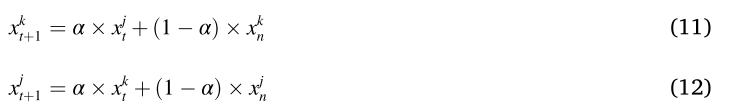
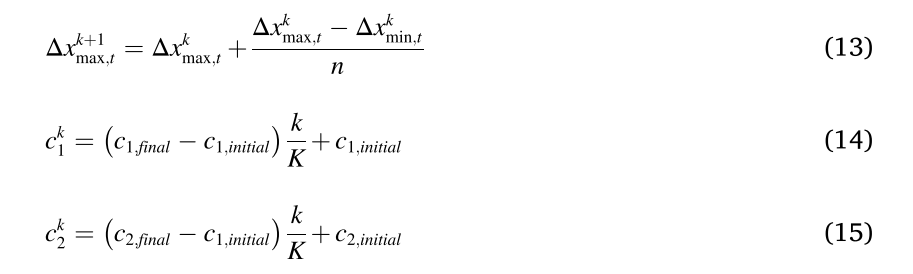
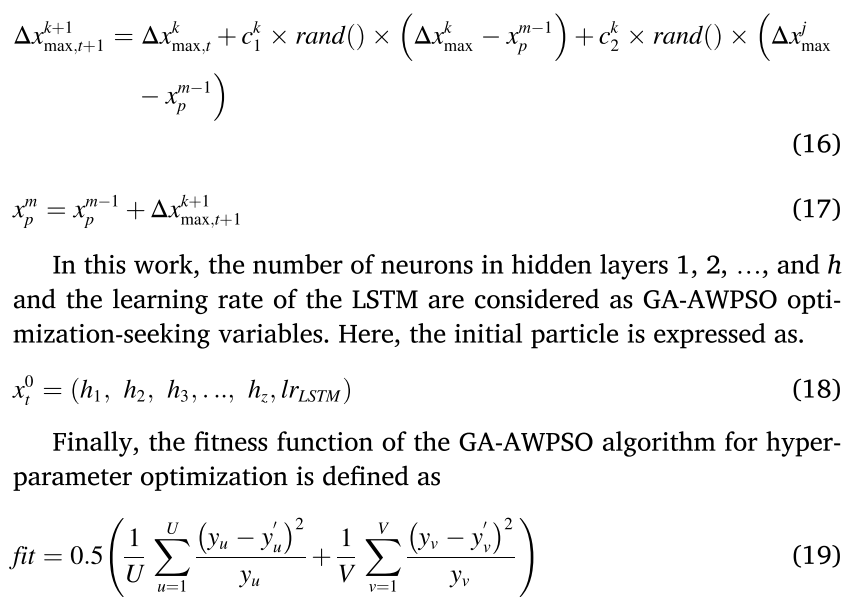

## Step
* Step3: GA-AWPSO 최적화 알고리즘 파라미터 설정, 최적화할 LSTM-GAM 하이퍼파라미터 범위 설정
* Step4: LSTM-GAM 예측모델 구성, 각 입자의 적합도를 수식 (19)에 따라 설정
* Step5: LSTM-GAM 학습하고, 각 입자의 적합도 계산, 적합도 크기정렬하고, 각 입자를 로컬 최적 입자로 사용
* Step6: 입자 업데이트 (속도 및 위치), 생성된 인구 인코딩, 선택,교차,돌연변이 과정 적용
* Step7: 입자 적합도를 다시 계산하고, 적합도 크기 정렬, 로컬 최적입자 표시(현재 입자에서 최적적합도), 글로벌 최적 입자 표시(전체인구에서 최소 적합도)
* Step8: P_p,best, G_p,best 및 G_g,best값 비교하여, 로컬 및 글로벌 최적값 선택
* Step9: 알고리즘 종료조건 충족할 때까지 입자 속오와 위치를 업데이트, 최대 반복 횟수에 도달하면 하이퍼 파라미터 반환

In [4]:
# 하이퍼파라미터 초기화
def initialize_particles():
    particles = []
    for _ in range(num_particles):
        learning_rate = random.uniform(*learning_rate_range)
        hidden_size1 = random.randint(*hidden_size_range)
        hidden_size2 = random.randint(*hidden_size_range)
        particle = {
            'learning_rate': learning_rate,
            'hidden_size1': hidden_size1,
            'hidden_size2': hidden_size2,
            'velocity_lr': 0.0,
            'velocity_hs1': 0.0,
            'velocity_hs2': 0.0,
            'best_position': {
                'learning_rate': learning_rate, 
                'hidden_size1': hidden_size1,
                'hidden_size2': hidden_size2
            },
            'best_fitness': float('inf')
        }
        particles.append(particle)
    return particles

# 하이퍼파라미터 적합도 함수
def fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs):
    model = LSTMWithAttention(input_size, particle['hidden_size1'], particle['hidden_size2'], output_size)
    optimizer = optim.Adam(model.parameters(), lr=particle['learning_rate'])
    _, val_losses = train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs)
    return 0.5 * val_losses[-1]

# PSO 속도 및 위치 업데이트
def update_velocity(particle, global_best_position, w):
    r1, r2 = random.random(), random.random()
    particle['velocity_lr'] = (w * particle['velocity_lr'] + 
                               c1 * r1 * (particle['best_position']['learning_rate'] - particle['learning_rate']) + 
                               c2 * r2 * (global_best_position['learning_rate'] - particle['learning_rate']))
    particle['velocity_hs1'] = (w * particle['velocity_hs1'] + 
                                c1 * r1 * (particle['best_position']['hidden_size1'] - particle['hidden_size1']) + 
                                c2 * r2 * (global_best_position['hidden_size1'] - particle['hidden_size1']))
    particle['velocity_hs2'] = (w * particle['velocity_hs2'] + 
                                c1 * r1 * (particle['best_position']['hidden_size2'] - particle['hidden_size2']) + 
                                c2 * r2 * (global_best_position['hidden_size2'] - particle['hidden_size2']))

def update_position(particle):
    particle['learning_rate'] += particle['velocity_lr']
    particle['learning_rate'] = np.clip(particle['learning_rate'], *learning_rate_range)
    particle['hidden_size1'] += particle['velocity_hs1']
    particle['hidden_size1'] = int(np.clip(particle['hidden_size1'], *hidden_size_range))
    particle['hidden_size2'] += particle['velocity_hs2']
    particle['hidden_size2'] = int(np.clip(particle['hidden_size2'], *hidden_size_range))

# 교차 함수
def crossover(p1, p2):
    child = {
        'velocity_lr': 0.0,
        'velocity_hs1': 0.0,
        'velocity_hs2': 0.0,
        'best_position': {'learning_rate': None, 'hidden_size1': None, 'hidden_size2': None},
        'best_fitness': float('inf')
    }
    if random.random() < crossover_rate:
        child['learning_rate'] = (p1['learning_rate'] + p2['learning_rate']) / 2
        child['hidden_size1'] = (p1['hidden_size1'] + p2['hidden_size1']) / 2
        child['hidden_size2'] = (p1['hidden_size2'] + p2['hidden_size2']) / 2
    else:
        if p1['best_fitness'] < p2['best_fitness']:
            child['learning_rate'] = p1['learning_rate']
            child['hidden_size1'] = p1['hidden_size1']
            child['hidden_size2'] = p1['hidden_size2']
        else:
            child['learning_rate'] = p2['learning_rate']
            child['hidden_size1'] = p2['hidden_size1']
            child['hidden_size2'] = p2['hidden_size2']
    child['best_position'] = {
        'learning_rate': child['learning_rate'], 
        'hidden_size1': child['hidden_size1'],
        'hidden_size2': child['hidden_size2']
    }
    return child

In [8]:
def ga_awpso_optimize(x_train, y_train, x_val, y_val, num_epochs):
    particles = initialize_particles()  # 초기 입자 설정
    global_best_position = {'learning_rate': 0, 'hidden_size1': 0, 'hidden_size2': 0}
    global_best_fitness = float('inf')
    
    iteration = 0
    history = {
        'learning_rate': [],
        'hidden_size1': [],
        'hidden_size2': [],
        'fitness': []
    }
    
    while iteration < num_iterations:
        print(f'Iteration {iteration+1}/{num_iterations}')
        
        # 각 입자의 적합도 평가
        for i, particle in enumerate(particles):
            print(f'  Evaluating Particle {i+1}')
            fitness = fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs)
            
            print(f'  Particle {i+1}: LR={particle["learning_rate"]:.6f}, HS1={particle["hidden_size1"]}, HS2={particle["hidden_size2"]}, Fitness={fitness:.4f}')
            
            if fitness < particle['best_fitness']:
                particle['best_fitness'] = fitness
                particle['best_position'] = {
                    'learning_rate': particle['learning_rate'], 
                    'hidden_size1': particle['hidden_size1'],
                    'hidden_size2': particle['hidden_size2']
                }
            
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = {
                    'learning_rate': particle['learning_rate'], 
                    'hidden_size1': particle['hidden_size1'],
                    'hidden_size2': particle['hidden_size2']
                }
        
        # 적응 가중치 및 학습 인자 업데이트
        w = w_initial - (w_initial - w_final) * (iteration / num_iterations)
        
        # 속도 및 위치 업데이트
        for i, particle in enumerate(particles):
            update_velocity(particle, global_best_position, w)
            update_position(particle)
        
        # GA 교차
        new_particles = []
        for i in range(0, len(particles), 2):
            if i + 1 < len(particles):
                child = crossover(particles[i], particles[i + 1])
                new_particles.append(child)
                print(f'  Crossover: Created new particle with LR={child["learning_rate"]:.6f}, HS1={child["hidden_size1"]}, HS2={child["hidden_size2"]}')
                
        # GA 돌연변이
        for particle in new_particles:
            if random.random() < mutation_rate:
                particle['learning_rate'] = random.uniform(*learning_rate_range)
                particle['hidden_size1'] = random.randint(*hidden_size_range)
                particle['hidden_size2'] = random.randint(*hidden_size_range)
                print(f'  Mutation: Modified particle with LR={particle["learning_rate"]:.6f}, HS1={particle["hidden_size1"]}, HS2={particle["hidden_size2"]}')
        
        # 새로운 자손 입자들의 적합도 평가 및 군집 재구성
        all_particles = particles + new_particles
        all_particles.sort(key=lambda p: p['best_fitness'])
        particles = all_particles[:num_particles]  # 적합도가 높은 입자로 군집 재구성
        print('Reconstructed swarm with the best particles based on fitness.')

        for particle in particles:
            fitness = fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs)
            print(f'  Evaluating Particle after reconstruction: LR={particle["learning_rate"]:.6f}, HS1={particle["hidden_size1"]}, HS2={particle["hidden_size2"]}, Fitness={fitness:.4f}')
            
            if fitness < particle['best_fitness']:
                particle['best_fitness'] = fitness
                particle['best_position'] = {
                    'learning_rate': particle['learning_rate'], 
                    'hidden_size1': particle['hidden_size1'],
                    'hidden_size2': particle['hidden_size2']
                }
            
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = {
                    'learning_rate': particle['learning_rate'], 
                    'hidden_size1': particle['hidden_size1'],
                    'hidden_size2': particle['hidden_size2']
                }
        
        print(f'Best Fitness: {global_best_fitness:.4f}, Best LR: {global_best_position["learning_rate"]:.6f}, Best HS1: {global_best_position["hidden_size1"]}, Best HS2: {global_best_position["hidden_size2"]}')
        
        history['learning_rate'].append(global_best_position['learning_rate'])
        history['hidden_size1'].append(global_best_position['hidden_size1'])
        history['hidden_size2'].append(global_best_position['hidden_size2'])
        history['fitness'].append(global_best_fitness)
        
        iteration += 1
    
    return global_best_position, history


## GA-AWPSO 연동학습

In [9]:
# 하이퍼파라미터 설정
input_size = 10
output_size = 1
num_epochs = 50

# GA-AWPSO 파라미터 설정
num_particles = 5
num_iterations = 10
c1 = 1.5
c2 = 1.5
w_initial = 0.9
w_final = 0.4
mutation_rate = 0.1
crossover_rate = 0.4

# 하이퍼파라미터 범위 설정
learning_rate_range = [0.0001, 0.01]
hidden_size_range = [10, 100]

In [10]:
# 데이터 생성
x_train = torch.randn(64, 100, input_size)
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)
y_test = torch.randn(16, output_size)

Iteration 1/10
  Evaluating Particle 1
Epoch [10/50], Train Loss: 0.9560, Val Loss: 1.0866
Epoch [20/50], Train Loss: 0.9521, Val Loss: 1.0742
Epoch [30/50], Train Loss: 0.9445, Val Loss: 1.0748
Epoch [40/50], Train Loss: 0.9293, Val Loss: 1.0620
Epoch [50/50], Train Loss: 0.8947, Val Loss: 1.0388
  Particle 1: LR=0.000258, HS1=33, HS2=72, Fitness=0.5194
  Evaluating Particle 2
Epoch [10/50], Train Loss: 0.6945, Val Loss: 1.0228
Epoch [20/50], Train Loss: 0.1334, Val Loss: 2.0816
Epoch [30/50], Train Loss: 0.0266, Val Loss: 2.0634
Epoch [40/50], Train Loss: 0.0063, Val Loss: 1.9453
Epoch [50/50], Train Loss: 0.0026, Val Loss: 1.8128
  Particle 2: LR=0.007028, HS1=77, HS2=31, Fitness=0.9064
  Evaluating Particle 3
Epoch [10/50], Train Loss: 0.6654, Val Loss: 1.1102
Epoch [20/50], Train Loss: 0.2165, Val Loss: 1.2833
Epoch [30/50], Train Loss: 0.0228, Val Loss: 1.3384
Epoch [40/50], Train Loss: 0.0098, Val Loss: 1.5460
Epoch [50/50], Train Loss: 0.0028, Val Loss: 1.5477
  Particle 3: LR=

Epoch [20/50], Train Loss: 0.9577, Val Loss: 1.0948
Epoch [30/50], Train Loss: 0.9568, Val Loss: 1.0877
Epoch [40/50], Train Loss: 0.9555, Val Loss: 1.0883
Epoch [50/50], Train Loss: 0.9540, Val Loss: 1.0904
  Particle 3: LR=0.000100, HS1=10, HS2=100, Fitness=0.5452
  Evaluating Particle 4
Epoch [10/50], Train Loss: 0.8187, Val Loss: 1.1053
Epoch [20/50], Train Loss: 0.6323, Val Loss: 1.5043
Epoch [30/50], Train Loss: 0.3057, Val Loss: 1.8507
Epoch [40/50], Train Loss: 0.0816, Val Loss: 2.6914
Epoch [50/50], Train Loss: 0.0237, Val Loss: 2.3466
  Particle 4: LR=0.002223, HS1=47, HS2=78, Fitness=1.1733
  Evaluating Particle 5
Epoch [10/50], Train Loss: 0.9577, Val Loss: 1.0926
Epoch [20/50], Train Loss: 0.9561, Val Loss: 1.0918
Epoch [30/50], Train Loss: 0.9543, Val Loss: 1.0876
Epoch [40/50], Train Loss: 0.9520, Val Loss: 1.0865
Epoch [50/50], Train Loss: 0.9490, Val Loss: 1.0852
  Particle 5: LR=0.000100, HS1=21, HS2=86, Fitness=0.5426
  Crossover: Created new particle with LR=0.00017

Epoch [20/50], Train Loss: 0.9561, Val Loss: 1.0883
Epoch [30/50], Train Loss: 0.9548, Val Loss: 1.0893
Epoch [40/50], Train Loss: 0.9533, Val Loss: 1.0895
Epoch [50/50], Train Loss: 0.9514, Val Loss: 1.0877
  Particle 5: LR=0.000100, HS1=28, HS2=72, Fitness=0.5438
  Crossover: Created new particle with LR=0.000258, HS1=33, HS2=72
  Crossover: Created new particle with LR=0.000100, HS1=28.0, HS2=59.0
Reconstructed swarm with the best particles based on fitness.
Epoch [10/50], Train Loss: 0.9550, Val Loss: 1.0877
Epoch [20/50], Train Loss: 0.9500, Val Loss: 1.0848
Epoch [30/50], Train Loss: 0.9410, Val Loss: 1.0806
Epoch [40/50], Train Loss: 0.9230, Val Loss: 1.0741
Epoch [50/50], Train Loss: 0.8864, Val Loss: 1.0713
  Evaluating Particle after reconstruction: LR=0.000258, HS1=33, HS2=72, Fitness=0.5356
Epoch [10/50], Train Loss: 0.9578, Val Loss: 1.0871
Epoch [20/50], Train Loss: 0.9565, Val Loss: 1.0907
Epoch [30/50], Train Loss: 0.9552, Val Loss: 1.0904
Epoch [40/50], Train Loss: 0.9

Epoch [50/50], Train Loss: 0.9060, Val Loss: 1.0863
  Evaluating Particle after reconstruction: LR=0.000258, HS1=33, HS2=72, Fitness=0.5432
Epoch [10/50], Train Loss: 0.9576, Val Loss: 1.0886
Epoch [20/50], Train Loss: 0.9564, Val Loss: 1.0877
Epoch [30/50], Train Loss: 0.9550, Val Loss: 1.0903
Epoch [40/50], Train Loss: 0.9531, Val Loss: 1.0890
Epoch [50/50], Train Loss: 0.9506, Val Loss: 1.0882
  Evaluating Particle after reconstruction: LR=0.000100, HS1=13, HS2=96, Fitness=0.5441
Epoch [10/50], Train Loss: 0.9634, Val Loss: 1.1176
Epoch [20/50], Train Loss: 0.9589, Val Loss: 1.0991
Epoch [30/50], Train Loss: 0.9569, Val Loss: 1.0871
Epoch [40/50], Train Loss: 0.9556, Val Loss: 1.0830
Epoch [50/50], Train Loss: 0.9541, Val Loss: 1.0838
  Evaluating Particle after reconstruction: LR=0.000100, HS1=28, HS2=76, Fitness=0.5419
Epoch [10/50], Train Loss: 0.9592, Val Loss: 1.0764
Epoch [20/50], Train Loss: 0.9567, Val Loss: 1.0835
Epoch [30/50], Train Loss: 0.9551, Val Loss: 1.0859
Epoch [4

Epoch [10/50], Train Loss: 0.9597, Val Loss: 1.1054
Epoch [20/50], Train Loss: 0.9561, Val Loss: 1.0826
Epoch [30/50], Train Loss: 0.9539, Val Loss: 1.0803
Epoch [40/50], Train Loss: 0.9501, Val Loss: 1.0840
Epoch [50/50], Train Loss: 0.9442, Val Loss: 1.0793
  Evaluating Particle after reconstruction: LR=0.000190, HS1=34, HS2=71, Fitness=0.5397
Epoch [10/50], Train Loss: 0.9579, Val Loss: 1.0941
Epoch [20/50], Train Loss: 0.9558, Val Loss: 1.0928
Epoch [30/50], Train Loss: 0.9529, Val Loss: 1.0868
Epoch [40/50], Train Loss: 0.9483, Val Loss: 1.0851
Epoch [50/50], Train Loss: 0.9401, Val Loss: 1.0813
  Evaluating Particle after reconstruction: LR=0.000157, HS1=35, HS2=84, Fitness=0.5406
Best Fitness: 0.5105, Best LR: 0.000252, Best HS1: 31, Best HS2: 80
Iteration 10/10
  Evaluating Particle 1
Epoch [10/50], Train Loss: 0.9567, Val Loss: 1.1026
Epoch [20/50], Train Loss: 0.9516, Val Loss: 1.0904
Epoch [30/50], Train Loss: 0.9414, Val Loss: 1.0991
Epoch [40/50], Train Loss: 0.9161, Val L

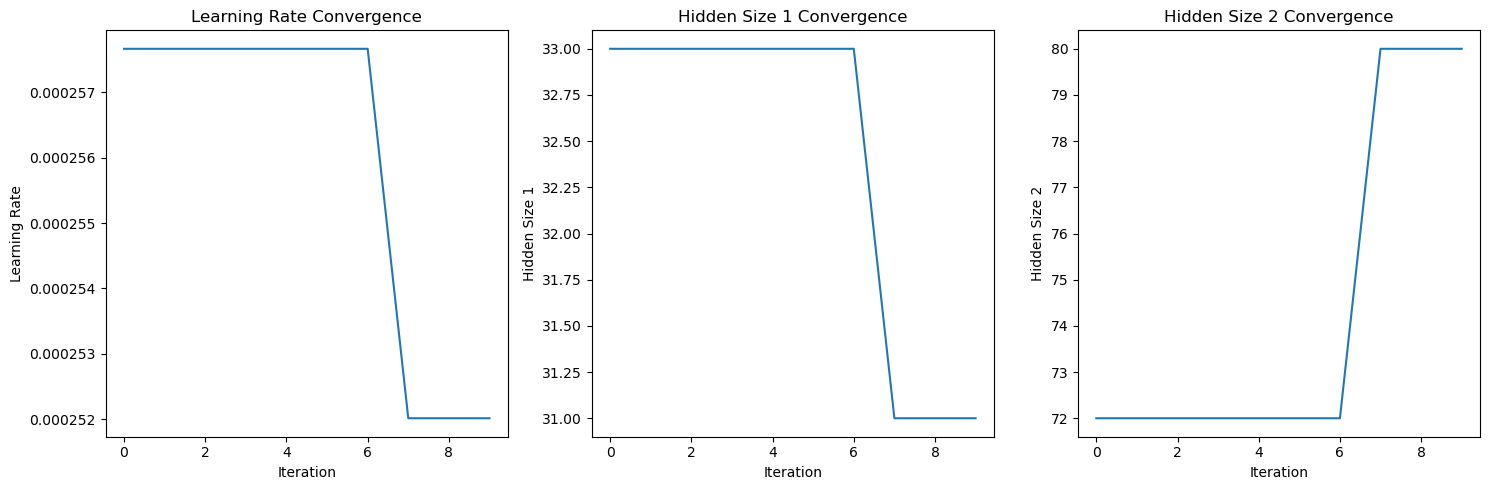

Epoch [10/50], Train Loss: 0.9569, Val Loss: 1.0964
Epoch [20/50], Train Loss: 0.9531, Val Loss: 1.0875
Epoch [30/50], Train Loss: 0.9469, Val Loss: 1.0872
Epoch [40/50], Train Loss: 0.9341, Val Loss: 1.0827
Epoch [50/50], Train Loss: 0.9060, Val Loss: 1.0793
Test Loss for the best model: 1.3357


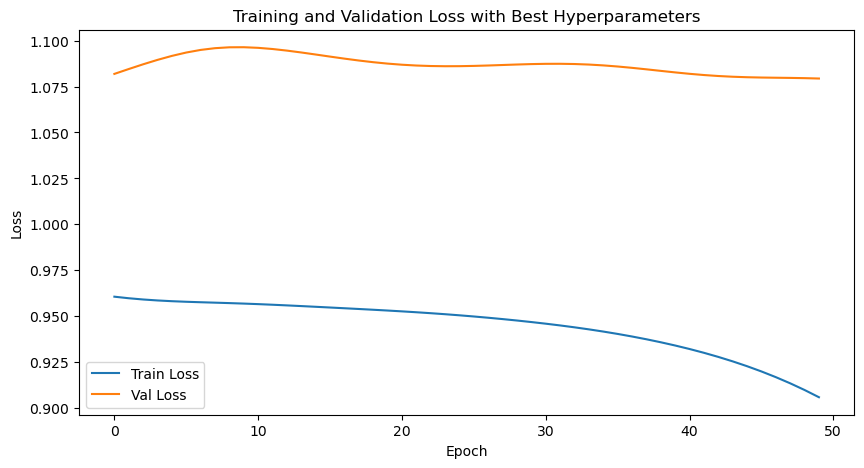

In [11]:
# 모델 학습 및 하이퍼파라미터 최적화
best_hyperparameters, history = ga_awpso_optimize(x_train, y_train, x_val, y_val, num_epochs)
print('Best Hyperparameters:', best_hyperparameters)

# 하이퍼파라미터 수렴 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['learning_rate'])
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Convergence')

plt.subplot(1, 3, 2)
plt.plot(history['hidden_size1'])
plt.xlabel('Iteration')
plt.ylabel('Hidden Size 1')
plt.title('Hidden Size 1 Convergence')

plt.subplot(1, 3, 3)
plt.plot(history['hidden_size2'])
plt.xlabel('Iteration')
plt.ylabel('Hidden Size 2')
plt.title('Hidden Size 2 Convergence')

plt.tight_layout()
plt.show()

# 최적 하이퍼파라미터로 모델 학습 및 테스트
best_model = LSTMWithAttention(input_size, best_hyperparameters['hidden_size1'], best_hyperparameters['hidden_size2'], output_size)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparameters['learning_rate'])
train_losses, val_losses = train_model(best_model, best_optimizer, x_train, y_train, x_val, y_val, num_epochs)
test_loss = test_model(best_model, x_test, y_test)
print(f'Test Loss for the best model: {test_loss:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Best Hyperparameters')
plt.legend()
plt.show()